In [1]:
import ppinetsim
import numpy as np
import matplotlib.pyplot as plt

In [14]:
parameters = ppinetsim.Parameters('parameter_settings/params_1.json')

In [15]:
degree_distributions, num_ppis = ppinetsim.run_simulation(parameters, verbose=True)

Text(0, 0.5, 'Frequency')

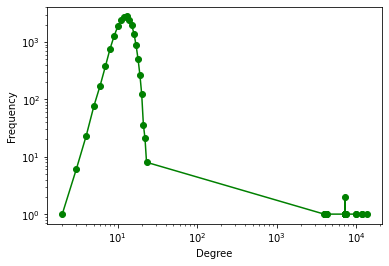

In [17]:
degree_distribution = degree_distributions[-1:]
freqs = np.asarray(np.unique(degree_distribution, return_counts=True))
plt.loglog(freqs[0,],freqs[1,],'go-')
plt.xlabel('Degree')
plt.ylabel('Frequency')